In [74]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.validation import check_is_fitted, check_array, FLOAT_DTYPES
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import _document_frequency
from sklearn.preprocessing import normalize
from catboost import CatBoostClassifier, CatBoostRegressor
from nltk.stem.porter import PorterStemmer
import torch
import torch.nn as nn
import torch.optim as optim


import string
import os
import warnings


tqdm.pandas()


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/youtube-video/youtube_sample_submission.csv
/kaggle/input/youtube-video/youtube_test.csv
/kaggle/input/youtube-video/youtube_train.csv
/kaggle/input/task-b/data.csv
/kaggle/input/students/students_train.csv
/kaggle/input/students/students_sample_submission.csv
/kaggle/input/students/students_test.csv
/kaggle/input/watermark/baseline_generation.ipynb
/kaggle/input/watermark/sample_submission_generation.npy
/kaggle/input/watermark/train_true_images.npy
/kaggle/input/watermark/train_corrupted_images.npy
/kaggle/input/watermark/test_corrupted_images.npy


# Task B

In [268]:
data = pd.read_csv("/kaggle/input/task-b/data.csv")
lr = LinearRegression()
lr.fit(data['x'].values.reshape(-1, 1), data['y'].values.reshape(-1, 1))
lr.coef_

<Axes: xlabel='x', ylabel='y'>

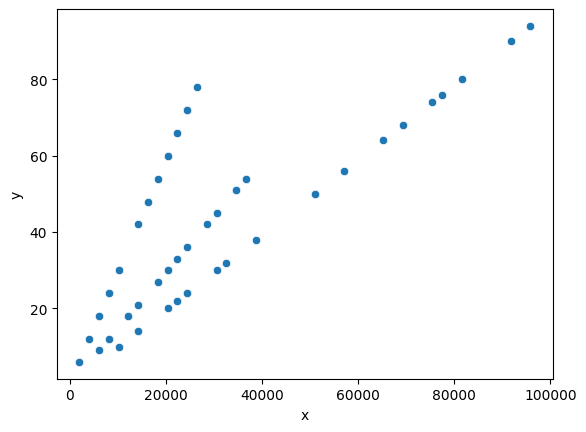

In [276]:
sns.scatterplot(data=data, x='x', y='y')

In [296]:
df

x   y
12  10195  10
19  14273  14
23  12234  18
24  18351  27
29   6117   9
30  14273  21
34  18351  27
36  12234  18
37  14273  21
38   8156  12
41  10195  30
42   8156  24
43   8156  24
46  10195  30
47   6117  18
48   6117  18
49  18351  54
50  16312  48
55   2039   6
57   2039   6
58  14273  42
59   4078  12

In [297]:
data['a'] = data['y'] / data['x']

In [299]:
data['a'].value_counts()

a
0.000981    20
0.001471    20
0.002943    20
Name: count, dtype: int64

In [341]:
data['y1'] = data['x'] * 0.000981
data['y2'] = data['x'] * 0.001470
data['y3'] = data['x'] * 0.002943

In [342]:
mean_absolute_percentage_error(data['y'], data['y1'])

0.3333333333333333

In [343]:
mean_absolute_percentage_error(data['y'], data['y2'])

0.33333333333333326

In [304]:
mean_absolute_percentage_error(data['y'], data['y3'])

1.0002589999999998

# C

In [97]:
L = np.array([[1, -1], [2, 1]])
mu, sigma = 0, 1 # mean and standard deviation
X = np.random.normal(mu, sigma, (3, 3))
L_X = np.array([np.sum(X[:2, :2] * L) , np.sum(X[:2, 1:] * L), np.sum(X[1:, :2] * L) , np.sum(X[1:, 1:] * L)])
t_X = np.stack([L_X, L_X], axis=1)
ans = np.sum(np.cov(t_X))
print(ans)

In [155]:
def convolve2D(image, kernel, padding=0, strides=1):
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]

    # Shape of Output Convolution
    xOutput = int(((xImgShape - xKernShape + 2 * padding) / strides) + 1)
    yOutput = int(((yImgShape - yKernShape + 2 * padding) / strides) + 1)
    output = np.zeros((xOutput, yOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding*2, image.shape[1] + padding*2))
        imagePadded[int(padding):int(-1 * padding), int(padding):int(-1 * padding)] = image
        print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for y in range(image.shape[1]):
        # Exit Convolution
        if y > image.shape[1] - yKernShape:
            break
        # Only Convolve if y has gone down by the specified Strides
        if y % strides == 0:
            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    if x % strides == 0:
                        output[x, y] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape]).sum()
                except:
                    break

    return output

In [ ]:
L_x = convolve2D(X, L)
t_X = np.stack([L_X, L_X], axis=1)
ans = np.sum(np.cov(t_X))
print(ans)

# G

In [212]:
def date_features(df, date_column):
    df['date_issued:year'] = df[date_column].dt.year
    df['date_issued:month'] = df[date_column].dt.month
    df['date_issued:day'] = df[date_column].dt.day
    df['date_issued:day_of_week'] = df[date_column].dt.day_of_week
    df['date_issued:day_of_year'] = df[date_column].dt.day_of_year
    del df[date_column]
    return df

In [192]:
train_g = pd.read_csv("/kaggle/input/students/students_train.csv", parse_dates=['Дата_Рождения'])
test_g = pd.read_csv("/kaggle/input/students/students_test.csv", parse_dates=['Дата_Рождения'])
submit = pd.read_csv("/kaggle/input/students/students_sample_submission.csv")

In [193]:
train_g

ID  Код_группы  Год_Поступления  Пол Основания   Изучаемый_Язык  \
0          0       20018             2016  Муж        СН  Английский язык   
1          1       20846             2016  Жен        БН  Английский язык   
2          2       14762             2013  Жен        СН  Английский язык   
3          3       17815             2015  Жен        СН  Английский язык   
4          4       17011             2014  Жен        ОО  Английский язык   
...      ...         ...              ...  ...       ...              ...   
11465  11465       17890             2015  Жен        СН    Немецкий язык   
11466  11466       19795             2015  Жен        СН  Английский язык   
11467  11467       17040             2014  Жен        СН  Английский язык   
11468  11468       19821             2017  Муж        ОО  Английский язык   
11469  11469       17383             2015  Муж        ОО  Английский язык   

      Дата_Рождения                                       Уч_Заведение  \
0        1994-04-12     ФГБОУ ВО Алтайский государственный университет   
1        1996-12-21  КГБ ПОУ Международный колледж сыроделия и проф...   
2        1992-08-01  ФГБОУ ВПО "Алтайский государственный университет"   
3        1994-02-06        КГБОУСПО "Алтайский строительный техникум "   
4        1997-03-08                                    МБОУ "Лицей №3"   
...             ...                                                ...   
11465    1990-07-23                                     ГОУ ВПО "БПГУ"   
11466    1997-10-18                                      МБОУ "СОШ №2"   
11467    1985-05-09    ГОУ ВПО "Алтайский государственный университет"   
11468    2000-02-11                                  МБОУ Гимназия №42   
11469    1993-09-19  ФГБОУ ВПО "Алтайский государственный университет"   

                        Где_Находится_УЗ  Год_Окончания_УЗ  ...  Общежитие  \
0      Россия, Алтайский край, г Барнаул            2016.0  ...        0.0   
1      Россия, Алтайский край, г Барнаул            2016.0  ...        1.0   
2              Алтайский край г. Барнаул            2013.0  ...        0.0   
3                      р.п.Степное озеро            2014.0  ...        0.0   
4              Алтайский край, Барнаул г            2014.0  ...        0.0   
...                                  ...               ...  ...        ...   
11465             Алтайский край,Бийск г            2010.0  ...        0.0   
11466     Тверская обл, ЗАТО Озёрный пгт            2015.0  ...        1.0   
11467          Алтайский край, Барнаул г            2007.0  ...        0.0   
11468         Алтайский край, г. Барнаул            2017.0  ...        0.0   
11469          Алтайский край, Барнаул г            2015.0  ...        0.0   

      Наличие_Матери Наличие_Отца Страна_Родители  Опекунство  Село  \
0                  1          1.0          Россия         0.0   1.0   
1                  1          1.0          Россия         0.0   0.0   
2                  0          0.0          Россия         0.0   0.0   
3                  1          1.0          Россия         0.0   0.0   
4                  0          0.0          Россия         0.0   0.0   
...              ...          ...             ...         ...   ...   
11465              0          0.0          Россия         0.0   0.0   
11466              0          0.0          Россия         0.0   1.0   
11467              0          0.0          Россия         0.0   0.0   
11468              1          1.0          Россия         0.0   0.0   
11469              0          0.0          Россия         0.0   1.0   

       Иностранец КодФакультета  СрБаллАттестата  Статус  
0             0.0          26.0             45.0       1  
1             0.0          34.0             57.0       0  
2             NaN          25.0             43.0       0  
3             0.0          25.0             44.0       1  
4             0.0          30.0             56.0       1  
...           ...           ...              ...    

In [195]:
train_g = date_features(train_g, "Дата_Рождения")
test_g = date_features(test_g, "Дата_Рождения")

In [196]:
train, val = train_test_split(train_g, test_size=0.2)

In [198]:
train_g["Уч_Заведение"].value_counts()

Уч_Заведение
ФГБОУ ВО Алтайский государственный университет                                   1108
ФГБОУ ВПО "Алтайский государственный университет"                                 900
ФГБОУ ВПО Алтайский государственный университет                                   101
ФГБОУ ВО Алтайский государственный технический университет им. И.И. Ползунова      74
Алтайский государственный университет                                              62
                                                                                 ... 
КГУ Уба-Форпостовская средняя школа                                                 1
СПТУ №37                                                                            1
МБОУ "Краснояровская СОШ"                                                           1
МБОУ Сычевская СОШ им К.Ф. Лебединской                                              1
МБОУ "Павловская СОШ" Павловского района Алтайского края                            1
Name: count, Length: 3255, dtype: int64

In [ ]:
train_g = train_g.drop(columns=["ID"])
train_g.info()

In [207]:
numerics = ['float16', 'float32', 'float64']

num_features = train_g.select_dtypes(include=numerics).columns
cat_features = [col for col in train_g.drop(columns=['Статус']).columns if col not in num_features]

In [208]:
for col in cat_features:
    train_g[col] = train_g[col].fillna("пропуск")
    test_g[col] = test_g[col].fillna("пропуск")

In [209]:
train, val = train_test_split(train_g, test_size=0.2, random_state=69)

In [210]:
cat_features

['Код_группы',
 'Год_Поступления',
 'Пол',
 'Основания',
 'Изучаемый_Язык',
 'Дата_Рождения',
 'Уч_Заведение',
 'Где_Находится_УЗ',
 'Страна_ПП',
 'Регион_ПП',
 'Город_ПП',
 'Наличие_Матери',
 'Страна_Родители',
 'date_issued:year',
 'date_issued:month',
 'date_issued:day',
 'date_issued:day_of_week',
 'date_issued:day_of_year']

In [ ]:
cat = CatBoostClassifier(eval_metric="F1", cat_features=cat_features)

cat.fit(
    X=train.drop(columns=['Статус']),
    y=train['Статус'],
    eval_set=(val.drop(columns=['Статус']), val['Статус']),
    verbose=50, 
    early_stopping_rounds=25
)

In [188]:
test_g = test_g.drop(columns="ID")
preds = cat.predict(test_g)

In [189]:
preds

array([0, 1, 1, ..., 1, 0, 0])

In [190]:
submit["Статус"] = preds

In [90]:
submit.to_csv("g_first.csv", index=None)

# E

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [78]:
def date_features(df, date_column):
    df['date_issued:year'] = df[date_column].dt.year
    df['date_issued:month'] = df[date_column].dt.month
    df['date_issued:day'] = df[date_column].dt.day
    df['date_issued:day_of_week'] = df[date_column].dt.day_of_week
    df['date_issued:day_of_year'] = df[date_column].dt.day_of_year
    del df[date_column]
    return df

In [79]:
train_e = pd.read_csv("/kaggle/input/youtube-video/youtube_train.csv")
test_e = pd.read_csv("/kaggle/input/youtube-video/youtube_test.csv")
submit_e = pd.read_csv("/kaggle/input/youtube-video/youtube_sample_submission.csv")

In [80]:
train_e = train_e.drop(columns='id')
test_e = test_e.drop(columns='id')

In [81]:
train_e['PublishDate'] = pd.to_datetime(train_e['PublishDate'].apply(lambda x: x.split('T')[0]))
test_e['PublishDate'] = pd.to_datetime(test_e['PublishDate'].apply(lambda x: x.split('T')[0]))
train_e = date_features(train_e, "PublishDate")
test_e = date_features(test_e, "PublishDate")

In [82]:
numerics = ['float16', 'float32', 'float64']

num_features = train_e.select_dtypes(include=numerics).columns
cat_features = [col for col in train_e.drop(columns=['ViewCount', 'Subtitles']).columns if col not in num_features]

In [83]:
for col in cat_features:
    train_e[col] = train_e[col].fillna("пропуск")
    test_e[col] = test_e[col].fillna("пропуск")

In [84]:
stemmer = PorterStemmer()

def text_preproc(text):
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    stems = " ".join([stemmer.stem(word) for word in text.split()])
    return stems

In [85]:
class Bm25Vectorizer(CountVectorizer):
    def __init__(self, input='content', encoding='utf-8',
                 decode_error='strict', strip_accents=None, lowercase=True,
                 preprocessor=None, tokenizer=None, analyzer='word',
                 stop_words=None, token_pattern=r"\w+",
                 ngram_range=(1, 1), max_df=1.0, min_df=1,
                 max_features=None, vocabulary=None, binary=False,
                 dtype=np.float64, norm='l2', use_idf=True, smooth_idf=True,
                 sublinear_tf=False):

        super(Bm25Vectorizer, self).__init__(
            input=input, encoding=encoding, decode_error=decode_error,
            strip_accents=strip_accents, lowercase=lowercase,
            preprocessor=preprocessor, tokenizer=tokenizer, analyzer=analyzer,
            stop_words=stop_words, token_pattern=token_pattern,
            ngram_range=ngram_range, max_df=max_df, min_df=min_df,
            max_features=max_features, vocabulary=vocabulary, binary=binary,
            dtype=dtype)

        self._tfidf = Bm25Transformer(norm=norm, use_idf=use_idf,
                                       smooth_idf=smooth_idf,
                                       sublinear_tf=sublinear_tf)

    # Broadcast the TF-IDF parameters to the underlying transformer instance
    # for easy grid search and repr

    @property
    def norm(self):
        return self._tfidf.norm

    @norm.setter
    def norm(self, value):
        self._tfidf.norm = value

    @property
    def use_idf(self):
        return self._tfidf.use_idf

    @use_idf.setter
    def use_idf(self, value):
        self._tfidf.use_idf = value

    @property
    def smooth_idf(self):
        return self._tfidf.smooth_idf

    @smooth_idf.setter
    def smooth_idf(self, value):
        self._tfidf.smooth_idf = value

    @property
    def sublinear_tf(self):
        return self._tfidf.sublinear_tf

    @sublinear_tf.setter
    def sublinear_tf(self, value):
        self._tfidf.sublinear_tf = value

    @property
    def idf_(self):
        return self._tfidf.idf_

    @idf_.setter
    def idf_(self, value):
        self._validate_vocabulary()
        if hasattr(self, 'vocabulary_'):
            if len(self.vocabulary_) != len(value):
                raise ValueError("idf length = %d must be equal "
                                 "to vocabulary size = %d" %
                                 (len(value), len(self.vocabulary)))
        self._tfidf.idf_ = value

    def _check_params(self):
        if self.dtype not in FLOAT_DTYPES:
            warnings.warn("Only {} 'dtype' should be used. {} 'dtype' will "
                          "be converted to np.float64."
                          .format(FLOAT_DTYPES, self.dtype),
                          UserWarning)

    def fit(self, raw_documents, y=None):
        """Learn vocabulary and idf from training set.

        Parameters
        ----------
        raw_documents : iterable
            an iterable which yields either str, unicode or file objects

        Returns
        -------
        self : TfidfVectorizer
        """
        self._check_params()
        X = super(Bm25Vectorizer, self).fit_transform(raw_documents)
        self._tfidf.fit(X)
        return self

    def fit_transform(self, raw_documents, y=None):
        """Learn vocabulary and idf, return term-document matrix.

        This is equivalent to fit followed by transform, but more efficiently
        implemented.

        Parameters
        ----------
        raw_documents : iterable
            an iterable which yields either str, unicode or file objects

        Returns
        -------
        X : sparse matrix, [n_samples, n_features]
            Tf-idf-weighted document-term matrix.
        """
        self._check_params()
        X = super(Bm25Vectorizer, self).fit_transform(raw_documents)
        self._tfidf.fit(X)
        # X is already a transformed view of raw_documents so
        # we set copy to False
        return self._tfidf.transform(X, copy=False)

    def transform(self, raw_documents, copy=True):
        """Transform documents to document-term matrix.

        Uses the vocabulary and document frequencies (df) learned by fit (or
        fit_transform).

        Parameters
        ----------
        raw_documents : iterable
            an iterable which yields either str, unicode or file objects

        copy : boolean, default True
            Whether to copy X and operate on the copy or perform in-place
            operations.

        Returns
        -------
        X : sparse matrix, [n_samples, n_features]
            Tf-idf-weighted document-term matrix.
        """
        check_is_fitted(self, '_tfidf', 'The tfidf vector is not fitted')

        X = super(Bm25Vectorizer, self).transform(raw_documents)
        return self._tfidf.transform(X, copy=False)


class Bm25Transformer(BaseEstimator, TransformerMixin):

    def __init__(self,k=1.2,b=0.75, norm="l2", use_idf=True, smooth_idf=True,
                 sublinear_tf=False):
        self.k = k
        self.b = b
        ######### tfidf的代码###########
        self.norm = norm
        self.use_idf = use_idf
        self.smooth_idf = smooth_idf
        self.sublinear_tf = sublinear_tf

    def fit(self, X, y=None):
        """Learn the idf vector (global term weights)

        Parameters
        ----------
        X : sparse matrix, [n_samples, n_features]
            a matrix of term/token counts
        """
        X = X.toarray()
        self.avdl = X.sum()/X.shape[0] #句子的平均长度
        # print("原来的fit的数据：\n",X)

        #计算每个词语的tf的值
        self.tf = X.sum(0)/X.sum()  #[M] #M表示总词语的数量
        self.tf = self.tf.reshape([1,self.tf.shape[0]]) #[1,M]
        # print("tf\n",self.tf)
        ######       原来tfidf的代码  ######

        X = check_array(X, accept_sparse=('csr', 'csc'))
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = X.dtype if X.dtype in FLOAT_DTYPES else np.float64

        if self.use_idf:
            n_samples, n_features = X.shape
            df = _document_frequency(X).astype(dtype)

            # perform idf smoothing if required
            df += int(self.smooth_idf)
            n_samples += int(self.smooth_idf)

            # log+1 instead of log makes sure terms with zero idf don't get
            # suppressed entirely.
            idf = np.log(n_samples / df) + 1
            self._idf_diag = sp.diags(idf, offsets=0,
                                      shape=(n_features, n_features),
                                      format='csr',
                                      dtype=dtype)

        return self

    def transform(self, X, copy=True):
        """Transform a count matrix to a tf or tf-idf representation

        Parameters
        ----------
        X : sparse matrix, [n_samples, n_features]
            a matrix of term/token counts

        copy : boolean, default True
            Whether to copy X and operate on the copy or perform in-place
            operations.

        Returns
        -------
        vectors : sparse matrix, [n_samples, n_features]
        """
        ########### 计算中间项  ###############
        cur_tf = np.multiply(self.tf, X.toarray()) #[N,M] #N表示数据的条数，M表示总词语的数量
        norm_lenght = 1 - self.b + self.b*(X.toarray().sum(-1)/self.avdl) #[N] #N表示数据的条数
        norm_lenght = norm_lenght.reshape([norm_lenght.shape[0],1]) #[N,1]
        X = (self.k+1)*cur_tf /(cur_tf +self.k*norm_lenght)
        ############# 结算结束  ################

        X = check_array(X, accept_sparse='csr', dtype=FLOAT_DTYPES, copy=copy)
        if not sp.issparse(X):
            X = sp.csr_matrix(X, dtype=np.float64)

        n_samples, n_features = X.shape

        if self.sublinear_tf:
            np.log(X.data, X.data)
            X.data += 1

        if self.use_idf:
            check_is_fitted(self, '_idf_diag', 'idf vector is not fitted')

            expected_n_features = self._idf_diag.shape[0]
            if n_features != expected_n_features:
                raise ValueError("Input has n_features=%d while the model"
                                 " has been trained with n_features=%d" % (
                                     n_features, expected_n_features))
            # *= doesn't work

            X = X * self._idf_diag

        if self.norm:
            X = normalize(X, norm=self.norm, copy=False)
        return X

    @property
    def idf_(self):
        # if _idf_diag is not set, this will raise an attribute error,
        # which means hasattr(self, "idf_") is False
        return np.ravel(self._idf_diag.sum(axis=0))

    @idf_.setter
    def idf_(self, value):
        value = np.asarray(value, dtype=np.float64)
        n_features = value.shape[0]
        self._idf_diag = sp.spdiags(value, diags=0, m=n_features,
                                    n=n_features, format='csr')

In [86]:
train_e['Subtitles'] = train_e.progress_apply(lambda x['Subtitles']: text_preproc(x), axis=1) 
test_e['Subtitles'] = test_e.progress_apply(lambda x['Subtitles']: text_preproc(x), axis=1) 

In [87]:
train_e["len_subtitles"] = train_e["Subtitles"].apply(lambda x: len(x))
test_e["len_subtitles"] = test_e["Subtitles"].apply(lambda x: len(x))

train_e["len_subtitles2"] = train_e["Subtitles"].apply(lambda x: len(x.split()))
test_e["len_subtitles2"] = test_e["Subtitles"].apply(lambda x: len(x.split()))

In [88]:
train_e

Channel                                          Subtitles  \
0         toplesofficial  я миллениал и я не занимаюсь сексом так часто ...   
1              postnauka  сервитуты это одно из прямых наследие римского...   
2               NaukaPRO  музыка существуют сенсоры измеряющие магнитное...   
3              postnauka  в наше время только ленивые не говорит о том к...   
4        user-rb8ux1no6j  дорогие друзья это честный рекламный ролик наш...   
...                  ...                                                ...   
5844           postnauka  в освоении ребенка нового слова ключевая пробл...   
5845           postnauka  опуск языка и наука которая с этим связана кор...   
5846  kurilka_gutenberga  музыка что я хотела сегодня вам рассказать у м...   
5847           postnauka  в истории как мы уже говорили один из популярн...   
5848           postnauka  когда мы говорим о патриотизме то как правило ...   

                  Category  ViewCount  date_issued:year  date_issued:month  \
0                Education       3019              2017                 12   
1     Science & Technology         25              2014                  9   
2     Science & Technology          7              2023                 11   
3     Science & Technology          5              2014                  6   
4                Education         10              2020                 10   
...                    ...        ...               ...                ...   
5844  Science & Technology          8              2015                 11   
5845  Science & Technology         30              2013                  6   
5846  Science & Technology          3              2019                  1   
5847  Science & Technology          4              2016                 12   
5848  Science & Technology          4              2015                  9   

      date_issued:day  date_issued:day_of_week  date_issued:day_of_year  \
0                  31                        6                      365   
1                   4                        3                      247   
2                  23                        3                      327   
3                  23                        0                      174   
4                   9                        4                      283   
...               ...                      ...                      ...   
5844                5                        3                      309   
5845                4                        1                      155   
5846               26                        5                       26   
5847               26                        0                      361   
5848               22                        1                      265   

      len_subtitles  len_subtitles2  
0             11894            1973  
1              9600            1502  
2             12131            1715  
3             11960            1754  
4              2572             444  
...             ...             ...  
5844          10196            1555  
5845          11215            1773  
5846          58929           10044  
5847          11010            1750  
5848          11683            1779  

[5849 rows x 11 columns]

In [89]:
train, val = train_test_split(train_e, test_size=0.15)

In [90]:
train

Channel                                          Subtitles  \
3529           postnauka  рассказ планетных системах вокруг белых карлик...   
3813           postnauka  занимаюсь представлениями древних египтян и на...   
1206           postnauka  ну я бы сказал так что и в рамках фрейм анализ...   
4650  kurilka_gutenberga  собственно первым теплоту pc так вот про близн...   
5682           postnauka  я уже упоминал так называемые orphan на и забо...   
...                  ...                                                ...   
2932      toplesofficial  и и я секс это весело да особенно со мной но я...   
3438           postnauka  было ли когданибудь такое историческое явление...   
3540           postnauka  музыка вообще современное общество она являетс...   
1329           postnauka  изучение мышления в когнитивной психологии и н...   
2970           postnauka  аплодисменты музыка ещё одна очень разумная оч...   

                  Category  ViewCount  date_issued:year  date_issued:month  \
3529  Science & Technology          7              2015                  8   
3813  Science & Technology          9              2015                 11   
1206  Science & Technology          1              2014                  4   
4650             Education          7              2015                  6   
5682  Science & Technology          7              2021                  1   
...                    ...        ...               ...                ...   
2932  Science & Technology       1577              2016                  6   
3438  Science & Technology          6              2016                  1   
3540  Science & Technology         10              2017                 12   
1329  Science & Technology         16              2015                 12   
2970  Science & Technology         41              2022                  1   

      date_issued:day  date_issued:day_of_week  date_issued:day_of_year  \
3529               18                        1                      230   
3813                2                        0                      306   
1206               22                        1                      112   
4650               17                        2                      168   
5682               11                        0                       11   
...               ...                      ...                      ...   
2932               18                        5                      170   
3438               29                        4                       29   
3540               18                        0                      352   
1329                7                        0                      341   
2970               26                        2                       26   

      len_subtitles  len_subtitles2  
3529          12641            1872  
3813           7701            1179  
1206           9000            1460  
4650          30983            4986  
5682           8859            1378  
...             ...             ...  
2932           6090             951  
3438           7908            1180  
3540          11744            1659  
1329          10168            1489  
2970           5326             808  

[4971 rows x 11 columns]

In [91]:
import gc
gc.collect()

666

In [ ]:
tfidf = TfidfVectorizer()
encoder = TruncatedSVD(n_components=200)

vectors = tfidf.fit_transform(train["Subtitles"])
embs = encoder.fit_transform(vectors)
train[[f"emb_{i}" for i in range(200)]] = embs

vectors = tfidf.transform(val["Subtitles"])
embs = encoder.transform(vectors)
val[[f"emb_{i}" for i in range(200)]] = embs

In [ ]:
cat = CatBoostRegressor(eval_metric="MAE", cat_features=cat_features)

cat.fit(
    X=train.drop(columns=['ViewCount', 'Subtitles']),
    y=train['ViewCount'],
    eval_set=(val.drop(columns=['ViewCount', 'Subtitles']), val['ViewCount']),
    verbose=50, 
    early_stopping_rounds=50
)

In [ ]:
vectors = tfidf.transform(test_e["Subtitles"])
embs = encoder.transform(vectors)
test_e[[f"emb_{i}" for i in range(200)]] = embs

In [ ]:
test_e = test_e.drop(columns="Subtitles")
preds = cat.predict(test_e)
submit_e["ViewCount"] = preds
submit_e.to_csv("e_200.csv", index=None)

# F

In [16]:
with open("/kaggle/input/watermark/train_true_images.npy", "rb") as f:
    train_true_images = np.load(f).astype(int)  # если не сделать эту конверсию типов, все будет очень плохо работать
with open("/kaggle/input/watermark/train_corrupted_images.npy", "rb") as f:
    train_corrupted_images = np.load(f).astype(int)  # если не сделать эту конверсию типов, все будет очень плохо работать

In [17]:
print(train_true_images.shape)
print(train_corrupted_images.shape)

(4000, 128, 128, 3)
(4000, 128, 128, 3)


In [ ]:
plt.imshow(train_true_images[10])

In [ ]:
plt.imshow(train_corrupted_images[10])

In [23]:
with open("/kaggle/input/watermark/test_corrupted_images.npy", "rb") as f:
    test_corrupted_images = np.load(f).astype(int)

test_corrupted_images.shape

(2000, 128, 128, 3)

In [25]:
def compute_metrics(true_images, pred_images):
    """
    true_mask[batch_size, 128, 128, 3]: np.array
    pred_mask[batch_size, 128, 128, 3]: np.array
    """
    assert true_images.shape[1:] ==  (128, 128, 3), 'Check true_mask shape'
    assert pred_images.shape[1:] ==  (128, 128, 3), 'Check pred_mask shape'
    assert true_images.shape == pred_images.shape, 'Mask shapes do not align'

    return mean_absolute_error(true_images.ravel(), pred_images.ravel())
    

In [26]:
metric = compute_metrics(train_true_images, train_corrupted_images).round(5)

print(f"Отклонение тривиальных предсказаний на обучающей выборке: {metric}")

Отклонение тривиальных предсказаний на обучающей выборке: 4.05303


In [31]:
from torch.utils.data import Dataset, DataLoader


In [55]:
class TrainSet(Dataset):
    def __init__(self, corrupted_imgs, true_imgs):
        self.corrupted_imgs = torch.from_numpy(corrupted_imgs).float()
        self.true_imgs = torch.from_numpy(true_imgs).float()
    
    def __len__(self):
        return len(self.true_imgs)
    
    def __getitem__(self, idx):
        return (
            self.corrupted_imgs[idx],
            self.true_imgs[idx]
        )
    

class TestSet(Dataset):
    def __init__(self, corrupted_imgs):
        self.corrupted_imgs = torch.from_numpy(corrupted_imgs).float()
        #self.true_imgs = torch.from_numpy(true_imgs)
    
    def __len__(self):
        return len(self.corrupted_imgs)
    
    def __getitem(self, idx):
        return (
            self.corrupted_imgs[idx]
        )

In [57]:
train_dataset = TrainSet(train_corrupted_images, train_true_images)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = TestSet(test_corrupted_images)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [58]:
print(train_dataset[2][0].size())

torch.Size([128, 128, 3])


In [67]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                            kernel_size=3, 
                            stride=2, 
                            padding=1, 
                            output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                            kernel_size=3, 
                            stride=2, 
                            padding=1, 
                            output_padding=1),
            nn.Sigmoid())
    def forward(self, x):
        x = x.reshape(-1, 3, 128, 128)
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    for data in train_loader:
        img, t_img = data
        img = img.to(device)
        t_img = t_img.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, t_img.reshape(-1, 3, 128, 128))
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

torch.save(model.state_dict(), 'conv_autoencoder.pth')

cuda
Epoch [1/50], Loss: 30236.8730
Epoch [1/50], Loss: 30659.4688
Epoch [1/50], Loss: 43445.1055
Epoch [1/50], Loss: 30597.8984
Epoch [1/50], Loss: 32115.7969
Epoch [1/50], Loss: 20391.6523
Epoch [1/50], Loss: 20743.3789
Epoch [1/50], Loss: 30274.3086
Epoch [1/50], Loss: 34585.6289
Epoch [1/50], Loss: 27154.5684
Epoch [1/50], Loss: 19343.3906
Epoch [1/50], Loss: 32383.5586
Epoch [1/50], Loss: 42259.6875
Epoch [1/50], Loss: 35549.0586
Epoch [1/50], Loss: 29906.5371
Epoch [1/50], Loss: 22535.7812
Epoch [1/50], Loss: 32977.0234
Epoch [1/50], Loss: 29790.4609
Epoch [1/50], Loss: 31868.5938
Epoch [1/50], Loss: 23852.4023
Epoch [1/50], Loss: 27879.6934
Epoch [1/50], Loss: 23064.1289
Epoch [1/50], Loss: 27017.0137
Epoch [1/50], Loss: 29542.0215
Epoch [1/50], Loss: 30460.1172
Epoch [1/50], Loss: 14489.8936
Epoch [1/50], Loss: 23496.6641
Epoch [1/50], Loss: 35781.3828
Epoch [1/50], Loss: 26261.2148
Epoch [1/50], Loss: 33546.4180
Epoch [1/50], Loss: 23677.0156
Epoch [1/50], Loss: 27824.2559
Epo

In [69]:
model.eval()
preds = []
for data in train_loader:
    with torch.no_grad():
        img, t_img = data
        img = img.to(device)
        output = model(img.reshape(-1, 3, 128, 128))
        preds.append(output.detach().cpu().numpy().reshape(-1, 128,128, 3))


In [70]:
preds

[array([[[[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00]],
 
         [[1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          [1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
          ...,
          [1.00000000e+00, 1.00000000e+00, 1.0000

In [ ]:
ans = np.stack(preds)
with open("sample_submission_generation.npy", "wb") as f:
    np.save(f, ans.astype('uint8'), allow_pickle=False)